In [27]:
import os,sys
import csv
import copy
import math

import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz

sys.path.append("/home/pgrover/Dropbox/PhD/Morphodynamic_Model/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil

from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *
import sed_trans
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Section 4 - An initial hump in unidirectional flow

The following is a simple test using the Gaussian Hump using the avalanche model. Typically I ran it once without the avalanche model and then again with the avalanche model to get an idea of the difference.

Again the eq. numbers referenced below are from: Long et al. (2008)

This test assumes that the sediment transport rate $q_{bed}$ is a power function of the current speed (e.g. Grass 1981) along with a steady flow in the channel and a rigid lid.

$q_{bed}=au^b$

$u=Q/h$

$h = s - z_b$

where $s$ is the datum, $a$ and $b$ are constants and $h$ is the water depth.

For the example in Section 4 in Long et al. (2008) the following values are used:

### Model constants

In [14]:
# Set up the constants

a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

###Setup###
Setup the Mesh, Boundary and Initial Conditions

Grid dx = 1.0
Grid nx = 300


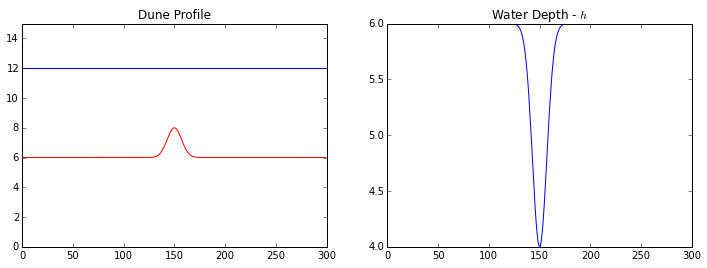

In [15]:
nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)
# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

surf = np.ones(nx) * s

fig = plt.figure(figsize=(12, 4)) 
plt.subplot(1,2,1)
plt.plot(xc,z,'r') 
plt.plot(xc,surf,'b')
plt.ylim([0,15])
plt.title('Dune Profile')
plt.subplot(1,2,2)
plt.plot(xc,h,'b')  
plt.title('Water Depth - $h$')

### Euler - WENO Scheme

Euler-WENO scheme.

Extracting
Done


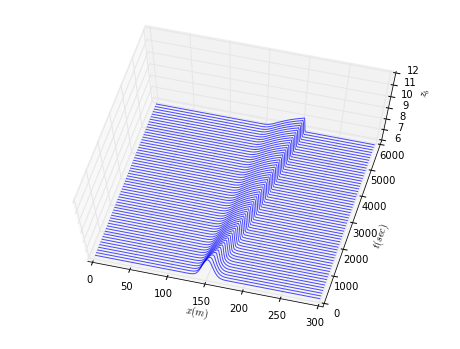

In [16]:
simTime = 6000. # Runtime
dt = 0.1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]

# Each time-step
for n in range(1,nt):  
    zn = zc.copy() 
    # Now iterate over the domain
    for i in range(0,nx): 
        #i=2
        # xloc = xc[i-(k-1):i+k]
        #xloc = get_stencil(xc,i-(k-1),i+k+1) #i+k-1-(i-(k-1)-1) = 2k -1 
        zloc = get_stencil(zn,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        #f_left,f_right = ENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,qloc,k)
        
        
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        zc[i] = zn[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
    
    # Apply the avalanche model
    #zc,iterations = avalanche_model(dx,xc,zc)
    #zc = z_updated.copy()
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b
    
    if (n*dt==600.):
        print 'Extracting'
        z600 = zc.copy() 
    if (n*dt == 2000.):
        z2000 = zc.copy()
        
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)
    
print 'Done'
lines = LineCollection(verts)
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
lines.set_alpha(0.7)
ax.add_collection3d(lines, zs=tsteps, zdir='y')
ax.set_xlim3d(0, 300)
ax.set_zlim3d(6, 12)
ax.set_ylim3d(0, 6000)
ax.set_zlabel('$z_b$')
ax.set_ylabel('$t(sec)$')
ax.set_xlabel('$x(m)$')

#view_init(elev=None, azim=None)
ax.view_init(70, -75)

### Results

Comparing the results from the simple upwinding model for t=600, 2000 and 6000 s we see that our model appears to be moving at the correct speed with respect to the analytical solution.

In [17]:
from weno import get_exact_solution
x_600, z_a600 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,600.)
x_2000, z_a2000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,2000.)
x_6000, z_a6000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,6000.)
np.shape(x_600),np.shape(z_a600)

((300,), (300,))

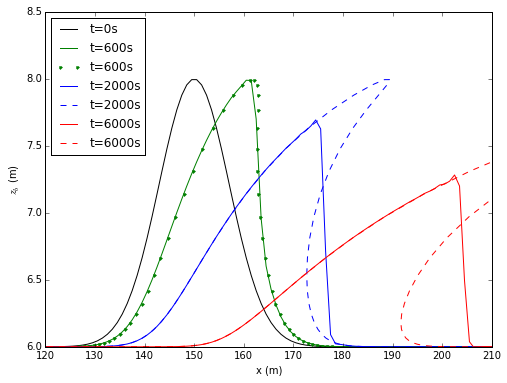

In [19]:
fig = plt.figure(figsize=(8, 6))
plt.plot(xc,z0,'k', label='t=0s') 

plt.plot(xc,z600,'g', label='t=600s')
plt.plot(x_600, z_a600,'g.', label='t=600s')

plt.plot(xc,z2000, label='t=2000s')
plt.plot(x_2000, z_a2000,'b--', label='t=2000s')

plt.plot(xc,zc, 'r', label='t=6000s')
plt.plot(x_6000, z_a6000,'r--', label='t=6000s')

plt.xlabel('x (m)')
plt.ylabel('$z_b$ (m)')
plt.xlim([120,210])
plt.ylim([6,6+2.5])
plt.legend(loc=2)

Now we will check the volume (area) to ensure we are conservative. 

In [21]:
area_old = trapz(z0, dx=dx)
area_new = trapz(zc, dx=dx)  
print('Area old: {0} Area new: {1} Iterations: {2}'.format(area_old,area_new,6000))

Area old: 1829.44907702 Area new: 1829.44907702 Iterations: 6000


It would appear that our solution is conservative. 

In [22]:
slopes = np.zeros(len(zc))
for i in range(len(xc)):
        zloc = get_stencil(zc,i,i+2)
        slopes[i] =get_slope(dx, zloc)
print min(slopes),max(slopes)


-35.1617277176 2.65708491902


## Running with the Avalanche Model

Now will run the Euler-WENO using the simple sediment transport equations above again but incorporate the avalanche model.

Grid dx = 1.0
Grid nx = 300
Extracting
Done


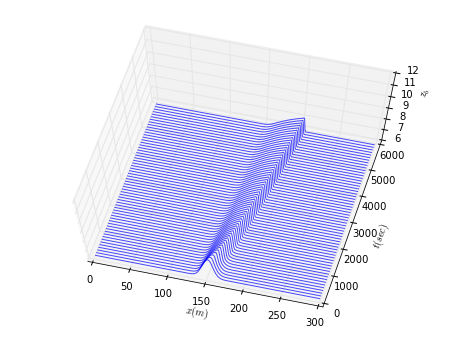

In [24]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)
# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

surf = np.ones(nx) * s

#--------------------------------
# Run the model
#--------------------------------

simTime = 6000. # Runtime
dt = 0.1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]

# Each time-step
for n in range(1,nt):  
    zn = zc.copy() 
    # Now iterate over the domain
    for i in range(0,nx): 
        #i=2
        # xloc = xc[i-(k-1):i+k]
        #xloc = get_stencil(xc,i-(k-1),i+k+1) #i+k-1-(i-(k-1)-1) = 2k -1 
        zloc = get_stencil(zn,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        #f_left,f_right = ENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,qloc,k)
        
        
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        zc[i] = zn[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
    
    # Apply the avalanche model
    zc,iterations = avalanche_model(dx,xc,zc)
    
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b
    
    if (n*dt==600.):
        print 'Extracting'
        z600 = zc.copy() 
    if (n*dt == 2000.):
        z2000 = zc.copy()
        
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)
    
print 'Done'
lines = LineCollection(verts)
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
lines.set_alpha(0.7)
ax.add_collection3d(lines, zs=tsteps, zdir='y')
ax.set_xlim3d(0, 300)
ax.set_zlim3d(6, 12)
ax.set_ylim3d(0, 6000)
ax.set_zlabel('$z_b$')
ax.set_ylabel('$t(sec)$')
ax.set_xlabel('$x(m)$')

#view_init(elev=None, azim=None)
ax.view_init(70, -75)

In [26]:
slopes = np.zeros(len(zc))
for i in range(len(xc)):
        zloc = get_stencil(zc,i,i+2)
        slopes[i] =get_slope(dx, zloc)
print min(slopes),max(slopes)

-29.928818709 2.617203165


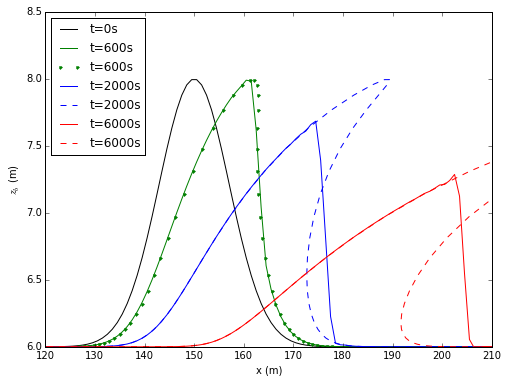

In [25]:
fig = plt.figure(figsize=(8, 6))
plt.plot(xc,z0,'k', label='t=0s') 

plt.plot(xc,z600,'g', label='t=600s')
plt.plot(x_600, z_a600,'g.', label='t=600s')

plt.plot(xc,z2000, label='t=2000s')
plt.plot(x_2000, z_a2000,'b--', label='t=2000s')

plt.plot(xc,zc, 'r', label='t=6000s')
plt.plot(x_6000, z_a6000,'r--', label='t=6000s')

plt.xlabel('x (m)')
plt.ylabel('$z_b$ (m)')
plt.xlim([120,210])
plt.ylim([6,6+2.5])
plt.legend(loc=2)

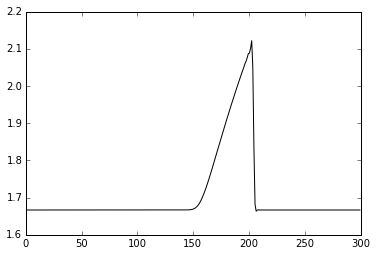

In [28]:
plt.plot(xc,u,'k', label='t=0s') 